<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/Crank_em_vull_matar_Nicolson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import numpy as np

def gauss_seidel(A, b, inicial, tol=1e-8, max_iter=1000):
    """
    Solves the linear system Ax = b using the Gauss-Seidel iteration method.

    Args:
        A (numpy.ndarray): The coefficient matrix (must be square and diagonally dominant for convergence).
        b (numpy.ndarray): The right-hand side vector.
        x0 (numpy.ndarray): The initial guess for the solution vector.
        tol (float): The tolerance for convergence.
        max_iter (int): The maximum number of iterations.

    Returns:
        numpy.ndarray: The approximate solution vector.
        int: The number of iterations taken.
    """
    n = A.shape[0]
    x = x0.copy() # Make a copy to avoid modifying the original x0

    for k in range(max_iter):
        x_old = x.copy()
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i]) # Use newly computed x values
            sum2 = np.dot(A[i, i+1:], x_old[i+1:]) # Use old x values

            # Ensure A[i, i] is not zero to prevent division by zero
            if A[i, i] == 0:
                raise ValueError(f"Diagonal element A[{i},{i}] is zero, Gauss-Seidel may not converge.")

            x[i] = (b[i] - sum1 - sum2) / A[i, i]

        # Check for convergence
        if np.linalg.norm(x - x_old, ord=np.inf) < tol:
            print(f"Gauss-Seidel converged in {k+1} iterations.")
            return np.array(x), k + 1

    print(f"Gauss-Seidel did not converge within {max_iter} iterations.")
    return np.array(x), max_iter

Bueno toca Crank-Nicolson  \
Si fas com derivades numèriques i reordenes queda:
$T_{i+1}^n (1+2\gamma)-\gamma·T_{i+1}^{n+1}-\gamma · T_{i+1}^{n-1} = T_i^n + \gamma · T_i^{n+1} + \gamma ·T_i
^{n-1} + Δt$\
que es pot escriure com un sistema de matrius to jodido pero bueno tenim llibreries\
Tenim dues matrius tridiagonals.\
 La de l'esquerre, matriu A, te per offdiagonal $-\gamma$ i per diagonal $(1+2\gamma)$ i multiplica un vector de les T a temps i+1\
 La de la dreta, matriu B, te per offdiagonal $\gamma$ i per diagonal $(1-2\gamma)$ i multiplica un vector de les T a temps i i li suma $Δt$\
 Necessitem puto invertir la matriu de l'esquerre, multiplicar tot a la dreta per l'inversa i tenim el vector d'incognites aïllat amb coses que coneixem (vamos que tenim el sistema resolt)

In [164]:
import numpy as np
from scipy.linalg import toeplitz
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.patches as pt

#definim matriu A
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40

#vamo a calcular:
alpha_var= kappa/(C_v*rho) #es la difusivitat

N= 101   # Mallat espaial, nombre de punts que tenim
x_0= 0.02 #per la cara, pq x_f ha de ser 0.02 (2 cm) i ha d'estar normalitzat així que ha de valer 1 JA SABEM PER QUÈ ENS HEM D'INVENTAR x_0
x_f= 0.02/x_0 #normalitzar, ja que \tilde{x}=x/x_0
x_i= 0
t_i= 0
t_0= x_0**2/alpha_var #\tilde{t}=t/t_0
t_f= 0.025 #ja està normalitzat, ho diu l'enunciat

P_ext= volts**2*sigma/(2*(x_0)**2) #calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 #KELVIN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("T_0=",T_0,"k")
T_init= 309.65/T_0   #CREC QUE HA D'ESTAR EN KELVIN PER LES UNITATS YOQUESE
print("T_init (JA NORMALITZADA)=",T_init,"k")

dx=x_f/(N-1)
dt_1= dx**2
dt_2= 0.5*dx**2
def CN(N, T_i, t_f, dt, dx):

  gamma= dt/(2*dx**2)

  dt_vect=np.ones((N-2,1))*dt
  dt_vect[0]= 2*gamma*T_i + dt
  dt_vect[-1]=2*gamma*T_i + dt

  T_i_vect = np.ones((N-2,1))*T_i
  fila1_A= (N-2)*[0]
  fila1_A [0]= 1+2*gamma
  fila1_A [1]= -gamma
  col_A = (N-2)*[0]
  col_A [1]= -gamma
  A = toeplitz(fila1_A,col_A)

  #print(A)

  fila1_B= (N-2)*[0]
  fila1_B [0]= 1-2*gamma
  fila1_B [1]= gamma
  col_B = (N-2)*[0]
  col_B [1]= gamma
  B = toeplitz(fila1_B,col_B)

  #print(B)

  inicial= np.array(99*[T_init])

  t_i = 0
  while t_i < t_f:
    b = np.matmul(B,T_i_vect) + dt_vect
    T_i_vect = gauss_seidel(A,b,T_i_vect,1e-8,1000)[0]
    t_i +=dt
  # for i in range(1):
  #   b = np.matmul(B,T_i_vect) + dt_vect
  #   c = 0
  #   inicial = 99*[0]
  #   inicial = np.array(inicial)
  #   anterior= np.array(99*[1])
  #   while True:
  #     print("lol",np.abs(max(inicial - anterior)))
  #     if np.abs(max(inicial - anterior)) < 1e-8:
  #       print("contador",c)
  #       break
  #     anterior = inicial.copy()
  #     c +=1
  #     for j in range(0,N-2):
  #       sum = np.sum(A[j]* inicial)- (A[j][j]*inicial[j])
  #       xj= (1/(A[j][j])) * b[j][0] - (1/(A[j][j]))*sum
  #       inicial[j] = xj
  # print (T_i_vect)

  #t_i=0
  #while t_i<t_f:
    #T_i_vect= np.matmul(Ainv,np.matmul(B,T_i_vect))+np.matmul(Ainv,dt_vect)
    #t_i = t_i +dt

  T_i_vect = T_i_vect*T_0-273.15
  T_i_vect =np.append(T_i_vect,[36.5])
  T_i_vect =np.append([36.5],T_i_vect)
  return T_i_vect

#pel primer cas tenim que delta t = delta x **2 --> gamma1 = 1/2
#pel segon tenim que delta t = 1/2 delta x**2 --> gamma2=1/4

T1=CN(101,T_init,t_f,dt_1,dx)
#T2=CN(101,T_init,t_f,dt_2,dx)

print (T1)
#print (T2)

T_0= 674.2857142857143 k
T_init (JA NORMALITZADA)= 0.4592266949152542 k
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 10 iterations.
Gauss-Seidel converged in 

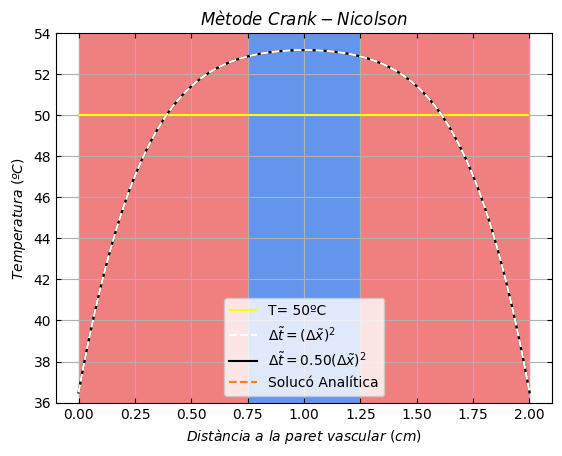

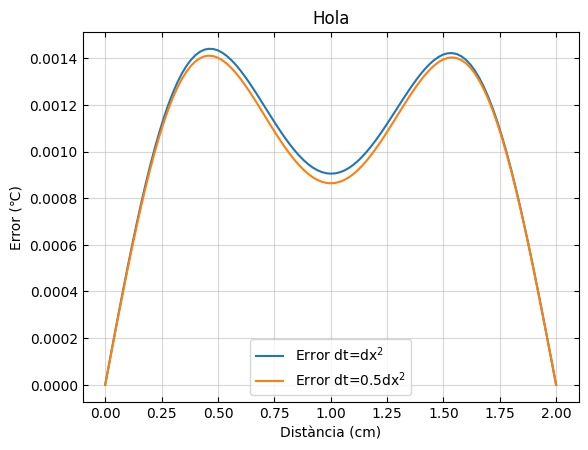

In [142]:

fig, ax= plt.subplots()

x=np.linspace(0,2,101)
ax.plot(x,T1)

#vale pillem només l'array per no executar again
T_real_analitica =[36.5, 37.66969107552376, 38.774358434195335, 39.81640154529612, 40.79821064375386, 41.72216161151641, 42.590611364820006, 43.40589332815745, 44.17031304193472, 44.88614393046629, 45.55562325343692, 46.180948261775995, 46.76427257678938, 47.307702809179034, 47.813295432258144, 48.28305392123838, 48.71892616796447, 49.12280217792255, 49.496512053786034, 49.84182426721014, 50.16044421807828, 50.45401307796095, 50.72410691220182, 50.97223607281086, 51.19984485225365, 51.40831138628192, 51.59894779218382, 51.77300052724229, 51.931650950796836, 52.0760160721066, 52.207149465221676, 52.32604233127694, 52.433624688043835, 52.53076666618608, 52.6182798914777, 52.6969189322416, 52.76738279144132, 52.83031642321015, 52.886312254103814, 52.93591169002019, 52.979606590514436, 53.01784069315329, 53.05101097157308, 53.07946891202897, 53.1035216944332, 53.12343326516634, 53.139425290298334, 53.15167797926523, 53.16033077050395, 53.165482872043015, 53.16719365156882, 53.165482872043015, 53.16033077050395, 53.15167797926523, 53.139425290298334, 53.12343326516634, 53.1035216944332, 53.07946891202897, 53.05101097157308, 53.01784069315329, 52.979606590514436, 52.93591169002019, 52.886312254103814, 52.83031642321015, 52.76738279144132, 52.6969189322416, 52.6182798914777, 52.53076666618608, 52.433624688043835, 52.32604233127694, 52.207149465221676, 52.0760160721066, 51.931650950796836, 51.77300052724229, 51.59894779218382, 51.40831138628192, 51.19984485225365, 50.97223607281086, 50.72410691220182, 50.45401307796095, 50.16044421807828, 49.84182426721014, 49.496512053786034, 49.12280217792255, 48.718926167964526, 48.28305392123838, 47.813295432258144, 47.307702809179034, 46.76427257678938, 46.180948261775995, 45.55562325343692, 44.88614393046629, 44.17031304193472, 43.40589332815745, 42.590611364820006, 41.72216161151641, 40.79821064375386, 39.81640154529612, 38.774358434195335, 37.66969107552376, 36.5]

lim_inf_y= float(np.floor(min(T1)))
altura= float(np.floor(max(T1)+1)-np.floor(min(T1)))

rectangle_cor= pt.Rectangle((0.75, lim_inf_y), 0.5, altura, color="cornflowerblue", alpha=1)
rectangle_esq= pt.Rectangle((0, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)
rectangle_dre= pt.Rectangle((1.25, lim_inf_y), 0.75, altura, color="lightcoral", alpha=1)

ax.add_patch(rectangle_cor)
ax.add_patch(rectangle_esq)
ax.add_patch(rectangle_dre)

plt.title(r"$Mètode\ Crank-Nicolson$")
plt.xlabel(r"$Distància\ a\ la\ paret\ vascular\ (cm)$")
plt.ylabel(r"$Temperatura\ (ºC)$")

ax.tick_params(direction='in', top=True, right=True)
plt.ylim(lim_inf_y, np.floor(max(T1)+1))
plt.hlines(50, 0, 2, color="yellow", label="T= 50ºC")

plt.plot(x, T1, color="white", label=r"$\Delta \tilde{t}= (\Delta \tilde{x})^2$", linestyle="--",zorder= 10)
plt.plot(x, T2, color="k", label=r"$\Delta \tilde{t}= 0.50(\Delta \tilde{x})^2$")
plt.plot(x, T_real_analitica, "--", label="Solucó Analítica",zorder=8)
plt.legend()
plt.grid("equal")
plt.show()

plt.figure()
plt.plot(x, np.abs(T1-T_real_analitica), label="Error dt=dx$^2$")
plt.plot(x, np.abs(T_real_analitica - T2), label="Error dt=0.5dx$^2$")
plt.xlabel("Distància (cm)")
plt.ylabel("Error (℃)")
plt.grid(True, alpha=0.5)
plt.title("Hola")
plt.legend()
plt.tick_params(direction='in', top=True, right=True)
plt.show()

In [154]:
import numpy as np
from scipy.linalg import toeplitz
from numpy.linalg import inv
import matplotlib.pyplot as plt
import matplotlib.patches as pt

#definim matriu A
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40

#vamo a calcular:
alpha_var= kappa/(C_v*rho) #es la difusivitat

N= 101   # Mallat espaial, nombre de punts que tenim
x_0= 0.02 #per la cara, pq x_f ha de ser 0.02 (2 cm) i ha d'estar normalitzat així que ha de valer 1 JA SABEM PER QUÈ ENS HEM D'INVENTAR x_0
x_f= 0.02/x_0 #normalitzar, ja que \tilde{x}=x/x_0
x_i= 0
t_i= 0
t_0= x_0**2/alpha_var #\tilde{t}=t/t_0
t_f= 0.025 #ja està normalitzat, ho diu l'enunciat

P_ext= volts**2*sigma/(2*(x_0)**2) #calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 #KELVIN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("T_0=",T_0,"k")
T_init= 309.65/T_0   #CREC QUE HA D'ESTAR EN KELVIN PER LES UNITATS YOQUESE
print("T_init (JA NORMALITZADA)=",T_init,"k")

dx=x_f/(N-1)
dt_1= dx**2
dt_2= 0.5*dx**2
def CN(N, T_initial_normalized, t_f, dt, dx):

  gamma= dt/(2*dx**2)

  # Normalized boundary temperature (36.5 C converted to Kelvin and then normalized)
  T_boundary_normalized = (36.5 + 273.15) / T_0

  # Source term (normalized dt, as per the equation text)
  source_term_per_timestep = dt

  # Initial condition for the internal points (N-2 points)
  T_current = np.ones((N-2, 1)) * T_initial_normalized

  # Define A matrix (left-hand side of A * T_new = b)
  # This is for the internal N-2 points
  fila1_A= (N-2)*[0]
  fila1_A [0]= 1+2*gamma
  fila1_A [1]= -gamma
  col_A = (N-2)*[0]
  col_A [0]= 1+2*gamma # First element of column is the same as first element of row
  col_A [1]= -gamma
  A = toeplitz(fila1_A,col_A)

  # Define B matrix (part of the right-hand side b = B * T_old + source_terms)
  # This is for the internal N-2 points
  fila1_B= (N-2)*[0]
  fila1_B [0]= 1-2*gamma
  fila1_B [1]= gamma
  col_B = (N-2)*[0]
  col_B [0]= 1-2*gamma # First element of column is the same as first element of row
  col_B [1]= gamma
  B = toeplitz(fila1_B,col_B)

  # Time stepping loop
  t_current = 0
  # Calculate number of steps to avoid floating point issues in while loop condition
  num_time_steps = int(np.round(t_f / dt))

  for _ in range(num_time_steps):
    # Calculate the right-hand side (b_vector) for the current time step
    # b_vector = B * T_old + Source_term
    b_vector = np.matmul(B, T_current) + source_term_per_timestep

    # Add boundary conditions to the b_vector (fixed temperature at 36.5C at boundaries)
    # These terms come from rearranging the Crank-Nicolson equation for the first and last internal nodes
    b_vector[0, 0] += gamma * T_boundary_normalized * 2  # T_0_old and T_0_new
    b_vector[-1, 0] += gamma * T_boundary_normalized * 2  # T_{N-1}_old and T_{N-1}_new

    # Gauss-Seidel iteration to solve A * T_next = b_vector
    T_next = T_current.copy() # Initial guess for T_next is the solution from the previous time step
    max_gauss_seidel_iterations = 1000
    tolerance = 1e-8

    for iteration in range(max_gauss_seidel_iterations):
      T_old_gs_iteration = T_next.copy()
      for j in range(N-2):
        # Gauss-Seidel update formula: T_next[j] = (b_vector[j] - sum(A[j, k] * T_next[k] for k < j) - sum(A[j, k] * T_old_gs_iteration[k] for k > j)) / A[j, j]
        s1 = np.dot(A[j, :j], T_next[:j, 0]) # Sum terms using newly computed T_next values
        s2 = np.dot(A[j, j+1:], T_old_gs_iteration[j+1:, 0]) # Sum terms using T_old_gs_iteration values
        T_next[j, 0] = (b_vector[j, 0] - s1 - s2) / A[j, j]

      # Check for convergence
      if np.linalg.norm(T_next - T_old_gs_iteration) < tolerance:
        # print(f"Gauss-Seidel converged in {iteration+1} iterations for time step {t_current/dt:.2f}")
        break

    T_current = T_next
    t_current += dt

  # At the end, apply denormalization and add boundary conditions
  T_final_denormalized = T_current.flatten() * T_0 - 273.15

  # Re-add the fixed boundary conditions (36.5 C) to the full array
  T_final_with_boundaries = np.insert(T_final_denormalized, 0, 36.5) # Add at the beginning (x=0)
  T_final_with_boundaries = np.append(T_final_with_boundaries, 36.5) # Add at the end (x=x_f)

  return T_final_with_boundaries

print (CN(101,T_init,t_f,dt_1,dx))

T_0= 674.2857142857143 k
T_init (JA NORMALITZADA)= 0.4592266949152542 k
[  36.5          26.62433551   16.70576795    6.7686866    -3.16279001
  -13.06494617  -22.91459684  -32.68921028  -42.36702419  -51.92715412
  -61.34969339  -70.61580338  -79.70779362  -88.60919089  -97.30479691
 -105.78073423 -114.0244801  -122.02488826 -129.77219865 -137.25803536
 -144.47539293 -151.41861168 -158.08334239 -164.46650117 -170.56621507
 -176.38175937 -181.91348729 -187.16275316 -192.1318298  -196.82382126
 -201.24257175 -205.39257176 -209.27886233 -212.90693833 -216.28265173
 -219.41211559 -222.30160965 -224.95748827 -227.38609135 -229.59365891
 -231.58624993 -233.36966597 -234.94937992 -236.33047057 -237.51756302
 -238.51477551 -239.3256728  -239.9532264  -240.39978176 -240.66703261
 -240.75600258 -240.6670341  -240.39978471 -239.9532308  -239.3256786
 -238.51478267 -237.51757148 -236.33048025 -234.94939074 -233.36967782
 -231.58626273 -229.59367253 -227.38610568 -224.95750317 -222.30162499
 -219.